# 7. Moving Beyond Linearity

# Non-Linear Modelling

## Wage dataset

In [1]:
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [3]:
wage = pd.read_csv('./data/Wage.csv')
wage = wage.drop(wage.columns[0], axis=1)

wage['education'] = wage['education'].map({'1. < HS Grad': 1.0, 
                                                 '2. HS Grad': 2.0, 
                                                 '3. Some College': 3.0,
                                                 '4. College Grad': 4.0,
                                                 '5. Advanced Degree': 5.0
                                                })

wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


## 7.8.1 Polynomial regression

In [4]:
degree = 4
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = patsy.dmatrix(f, wage)
y = np.asarray(wage['wage'])
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           2.77e-57
Time:                        18:18:33   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -184.1542     60.040     -3.067      0.002    -301.879     -66.430
x1            21.2455      5.887      3.609      0.000       9.703      32.788
x2            -0.5639      0.206     -2.736      0.006      -0.968      -0.160
x3             0.0068      0.003      2.221      0.026       0.001       0.013
x4         -3.204e-05   1.64e-05     -1.952      0.051   -6.42e-05    1.45e-07
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     5.67e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.67e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1]:
from sklearn.metrics import mean_squared_error

In [5]:
def confidence_interval(X, model):
    y_hat = model.fittedvalues
    mse = mean_squared_error(y_hat - y)
    cov = mse * np.linalg.inv(X.T @ X)
    var_f = np.diagonal((X @ cov) @ X.T)
    se       = np.sqrt(var_f)
    conf_int = 2*se
    return conf_int

def polyniminal_plot(model, data, x='age', y='wage'):
    conf_int = confidence_interval(X, model)
    y_hat = model.fittedvalues
    fig, ax = plt.subplots(figsize=(10,10))

    sns.scatterplot(x=x, y=y,
                    color='tab:gray',
                    alpha=0.2,
                    ax=ax,
                    data=data)

    sns.lineplot(x=data[x], y=y_hat, ax=ax, color='r')
    sns.lineplot(x=data[x], y=y_hat+conf_int, color='b')
    sns.lineplot(x=data[x], y=y_hat-conf_int, color='b')

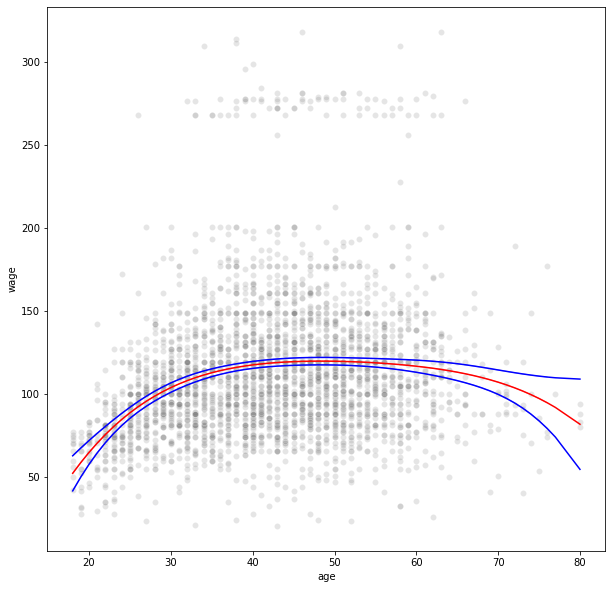

In [6]:
polyniminal_plot(model, wage)

### Selecting degrees of freedom for polynomial regression with ANOVA

**ISL Authors:** In performing a polynomial regression we must decide on the degree of the polynomial to use. One way to do this is by using hypothesis tests. We now fit models ranging from linear to a degree-5 polynomial and seek to determine the simplest model which is sufficient to explain the relationship between wage and age.

In [7]:
degree = 5
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = patsy.dmatrix(f, wage)
y = np.asarray(wage['wage'])

models = []

for i in range(1, degree+1):
    model = sm.OLS(y, X[:, 0:i+1]).fit()
    models += [model]

display(sm.stats.anova_lm(models[0], models[1], models[2], models[3], models[4]))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


**ISL Authors:** The p-value comparing the linear Model 1 to the quadratic Model 2 is essentially zero (<10−15), indicating that a linear fit is not sufficient. Sim- ilarly the p-value comparing the quadratic Model 2 to the cubic Model 3 is very low (0.0017), so the quadratic fit is also insufficient. The p-value comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is ap- proximately 5 % while the degree-5 polynomial Model 5 seems unnecessary because its p-value is 0.37. Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

In [8]:
models[-1].pvalues

array([0.75818559, 0.84262114, 0.77341959, 0.56366932, 0.4460959 ,
       0.36968197])

**Revision note:** ISL suggests that the above results should be same as for annova pvalues, but that isn;t observed here us statsmodels. Why?


**ISL Authors:** However, the ANOVA method works whether or not we used orthogonal polynomials; it also works when we have other terms in the model as well. For example, we can use anova() to compare these three models:

In [9]:
degree = 3
f = 'education +' + ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = patsy.dmatrix(f, wage)
y = np.asarray(wage['wage'])

models = []

for i in range(1, degree+1):
    model = sm.OLS(y, X[:, 0:i+1]).fit()
    models += [model]

# Compare models with ANOVA
display(sm.stats.anova_lm(models[0], models[1], models[2]))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,4.040005e+06,0.0,NaN,NaN,NaN
1,2997.0,3.902335e+06,1.0,137670.252849,109.712226,3.074043e-25
2,2996.0,3.759472e+06,1.0,142862.701185,113.850194,4.111586e-26


### Polynomial logistic regression with bootstrapped confidence intervals

In [10]:
wage['wage_above_250'] = (wage['wage'] > 250).astype(np.float64)
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,wage_above_250
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154,0.0
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020,0.0
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177,0.0
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293,0.0
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154,0.0


In [11]:
degree = 4
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = patsy.dmatrix(f, wage)
y = np.asarray(wage['wage_above_250'])
# Some test observations 
x1 = np.arange(20,81)
X_test  = np.array([np.ones(len(x1)), x1, np.power(x1, 2), np.power(x1, 3), np.power(x1, 4)]).T

model = sm.Logit(y, X).fit(disp=0)
y_hat = model.predict(X_test)

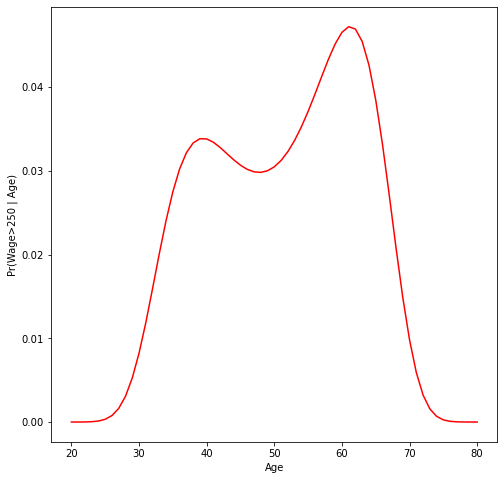

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
plot_df = pd.DataFrame({'Age': x1, 'Pr(Wage>250 | Age)': y_hat})
sns.lineplot(x='Age', y='Pr(Wage>250 | Age)', data=plot_df, color='red')

Here I've used the bootstrap sampling method to get estimates of f(x) for 1000 samples of the dataset. The 5th and 95th percentile of these estimates are shown in blue. The estimate for f(x) using the full dataset is shown in red. 

**Revision note:** I expected the 5th and 95th percentiles to correspond to the confidence intervals reported by the ISL authors. They are largely similar except for the higher bound for high values of age which tends to zero here but for the ISL authors tends to 1.

### Step function

In [13]:
steps = 6
cuts = pd.cut(wage['age'], steps)
X = np.asarray(pd.get_dummies(cuts))
y = np.asarray(wage['wage'])

model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)

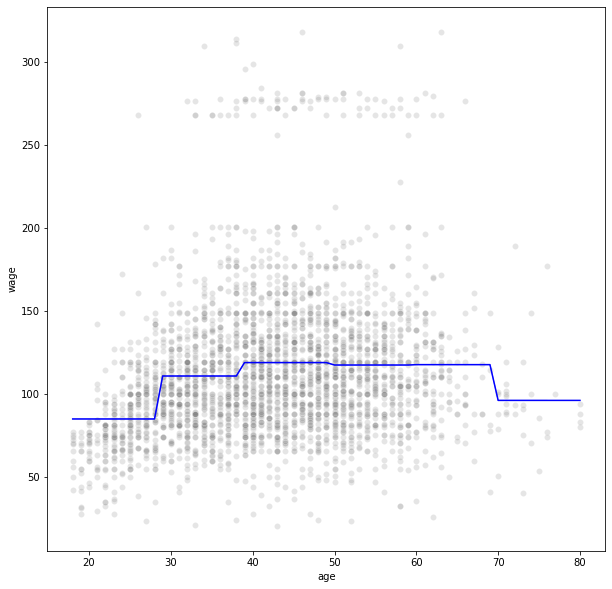

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=wage)

sns.lineplot(x=wage['age'], y=y_hat, ax=ax, color='blue')

sns.rugplot(a=y_hat, ax=ax)

## 7.8.2 Splines


### Basic Spline

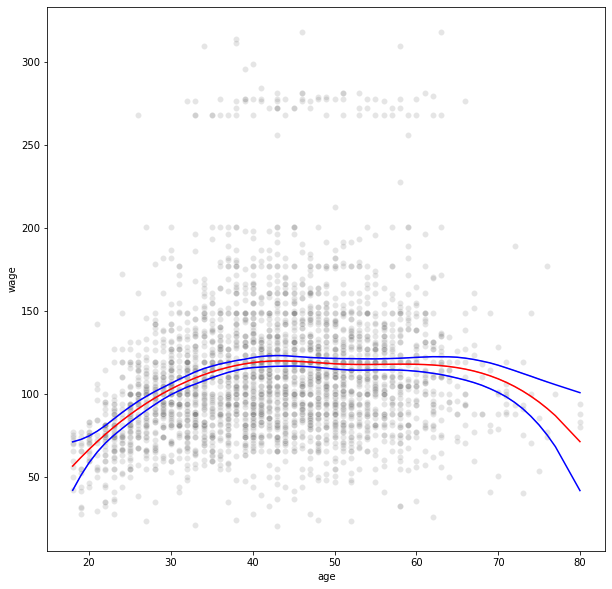

In [15]:
# Fit spline with 6 degrees of freedom
X = patsy.dmatrix('bs(age, df=7, degree=3, include_intercept=True)', wage)
y = np.asarray(wage['wage'])
model = sm.OLS(y, X).fit(disp=0)

polyniminal_plot(model, wage)

### Natural Spline

Natural and cyclic cubic regression splines are provided through the stateful transforms `cr()` and `cc()` respectively. 

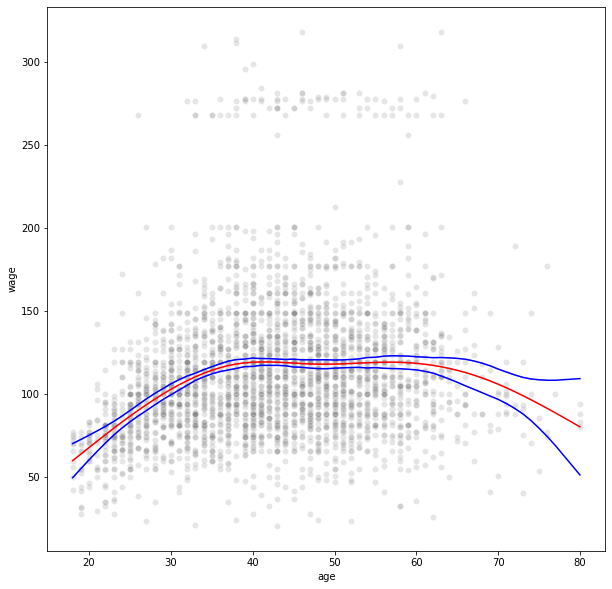

In [16]:
X = patsy.dmatrix('cr(age, df=7)', wage)
y = np.asarray(wage['wage'])
model = sm.OLS(y, X).fit(disp=0)

polyniminal_plot(model, wage)

Comparing the above two plots we can see the increased linearity of the natural spline at the boundaries of age. This seems to yield a slight increase in confidence at the extremes of age.

The ISLR authors cover smoothing splines in addition to the above. Smoothing splines seem to be poorly supported in python, I could only find `scipy.interpolate.UnivariateSpline`.



## 7.8.3 GAMs

**ISL Authors:** We now fit a GAM to predict wage using natural spline functions of year and age, treating education as a qualitative predictor, as in (7.16). Since this is just a big linear regression model using an appropriate choice of basis functions, we can simply do this using the lm() function.

In [17]:
X = patsy.dmatrix('cr(year, df=4)+cr(age, df=5) + education', wage)
y = np.asarray(wage['wage'])
model = sm.OLS(y, X).fit(disp=0)

In [18]:
def gam_plot(x1, x2, x3, data, model, figsize=(8,12)):
    fig, axes = plt.subplots(3,1, sharey=True, figsize=figsize)
    sns.lineplot(x=data[x1], y=model.fittedvalues, ax=axes[0])
    sns.lineplot(x=data[x2], y=model.fittedvalues, ax=axes[1])
    sns.boxplot(x=data[x3], y=model.fittedvalues, ax=axes[2])

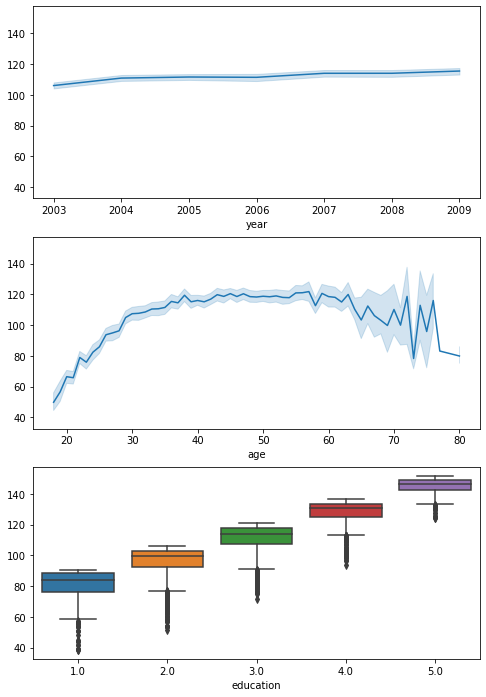

In [19]:
gam_plot('year', 'age', 'education', wage, model, figsize=(8,12))

Not quite the same as plots achived by ISL authors using R, but gives similar insight.

### GAM configurations with ANOVA

In [20]:
# Model 1
X = patsy.dmatrix('cr(age, df=5) + education', wage)
y = np.asarray(wage['wage'])
model1 = sm.OLS(y, X).fit(disp=0)
# Model 2
X = patsy.dmatrix('year+cr(age, df=5) + education', wage)
model2 = sm.OLS(y, X).fit(disp=0)
# Model 3
X = patsy.dmatrix('cr(year, df=4)+cr(age, df=5) + education', wage)
model3 = sm.OLS(y, X).fit(disp=0)

display(sm.stats.anova_lm(model1, model2, model3))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2994.0,3.750437e+06,0.0,NaN,NaN,NaN
1,2993.0,3.732809e+06,1.0,17627.473318,14.129318,0.000174
2,2991.0,3.731516e+06,2.0,1293.696286,0.518482,0.595477


The `Pr(>F)` of 0.000174 for `Model 2` suggests that it is significantly better than model 1 whereas with a pvalue > 0.05 model 3 does not seem to be significantly better than model 2.  

We condlude that inclusion of a linear year feature improves the model, but there is no evidence that a non-linear function of year improves the model.

In [21]:
display(model3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     149.3
Date:                Fri, 06 Mar 2020   Prob (F-statistic):          6.85e-212
Time:                        18:19:18   Log-Likelihood:                -14946.
No. Observations:                3000   AIC:                         2.991e+04
Df Residuals:                    2991   BIC:                         2.996e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.3493      1.799     21.317      0.000      34.822      41.877
x1             5.1741      1.366      3.788      0.000       2.496       7.853
x2             9.3791      1.242      7.550      0.000       6.943      11.815
x3            11.1966      1.294      8.654      0.000       8.660      13.733
x4            12.5995      1.519      8.292      0.000       9.620      15.579
x5           -22.7665      3.283     -6.935      0.000     -29.203     -16.330
x6            15.6588      2.343      6.684      0.000      11.066      20.252
x7            24.5870      1.987     12.372      0.000      20.690      28.484
x8            19.8888      2.546      7.810      0.000      14.896      24.882
x9             0.9812      7.953      0.123      0.902     -14.613      16.576
x10           15.2726      0.536     28.479      0.000      14.221      16.324
==============================================================================
Omnibus:                     1061.067   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5669.217
Skew:                           1.594   Prob(JB):                         0.00
Kurtosis:                       8.933   Cond. No.                     5.74e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

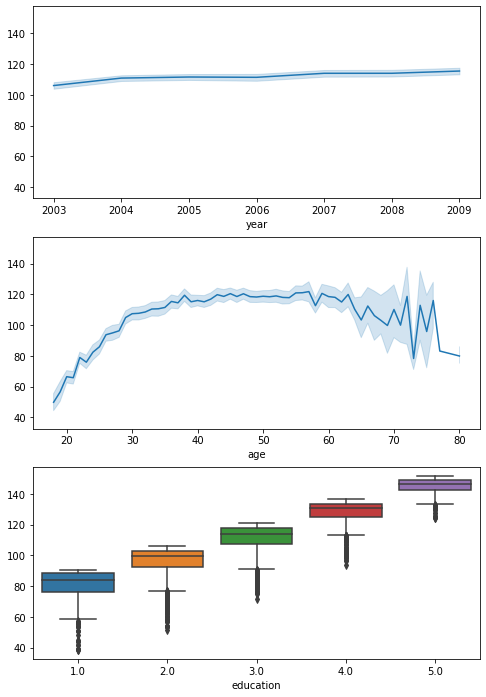

In [22]:
gam_plot('year', 'age', 'education', wage, model3)

Inspecting the pvalues for model 3 features we note a pvalue >0.05 for x9 which correspondes to the 5th degree of freedom for age. 

**Revision note:** The ISL authors report high pvalues for year features, which would reinforce the above ANOVA result, but we can't see that here. Perhaps the OLS `.summary()` is not equivalent to R's `summary(gam)`

### Local Regression GAM

In [23]:
x = np.asarray(wage['age'])
y = np.asarray(wage['wage'])

# local regression with span=0.7
wage['age_lowess'] = sm.nonparametric.lowess(y, x, frac=.7, return_sorted=False)

X = patsy.dmatrix('cr(year, df=4)+ age_lowess + education', wage)
y = np.asarray(wage['wage'])
model_gam = sm.OLS(y, X).fit(disp=0)
model_gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     239.0
Date:                Fri, 06 Mar 2020   Prob (F-statistic):          2.74e-215
Time:                        18:19:23   Log-Likelihood:                -14946.
No. Observations:                3000   AIC:                         2.990e+04
Df Residuals:                    2994   BIC:                         2.994e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.2295      5.977     -6.396      0.000     -49.949     -26.510
x1           -14.0090      1.973     -7.102      0.000     -17.877     -10.141
x2            -9.7151      1.886     -5.151      0.000     -13.413      -6.017
x3            -7.9607      1.917     -4.153      0.000     -11.719      -4.202
x4            -6.5447      2.091     -3.129      0.002     -10.645      -2.444
x5             1.0823      0.071     15.208      0.000       0.943       1.222
x6            15.3535      0.534     28.746      0.000      14.306      16.401
==============================================================================
Omnibus:                     1056.253   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5640.862
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       8.922   Cond. No.                     4.86e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.41e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

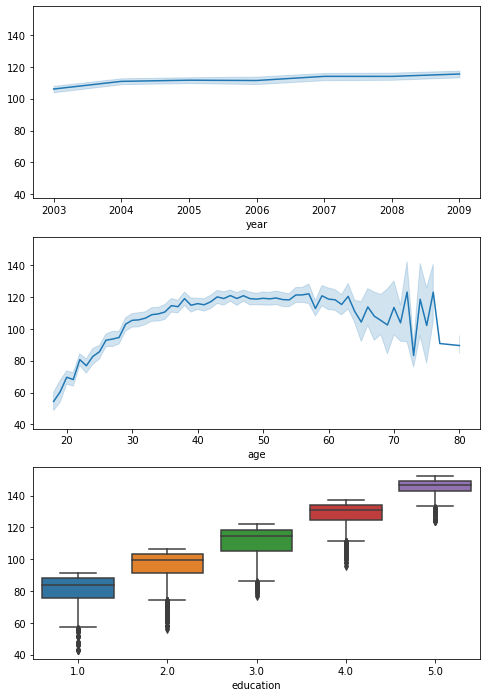

In [24]:
gam_plot('year', 'age', 'education', wage, model_gam)

In [25]:
age = np.asarray(wage['age'])
year = np.asarray(wage['year'])
wage_ = np.asarray(wage['wage'])

# local regression with span=0.7
wage['age_lowess'] = sm.nonparametric.lowess(wage_, age, frac=.5, return_sorted=False)
wage['year_lowess'] = sm.nonparametric.lowess(wage_, year, frac=.5, return_sorted=False)

X = patsy.dmatrix('year_lowess:age_lowess + education', wage)
y = np.asarray(wage['wage_above_250'])
model_gam2 = sm.OLS(y, X).fit(disp=0)
model_gam2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     55.21
Date:                Fri, 06 Mar 2020   Prob (F-statistic):           2.85e-24
Time:                        18:19:30   Log-Likelihood:                 1292.9
No. Observations:                3000   AIC:                            -2580.
Df Residuals:                    2997   BIC:                            -2562.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.030     -4.183      0.000      -0.185      -0.067
x1          7.453e-06   2.71e-06      2.753      0.006    2.15e-06    1.28e-05
x2             0.0232      0.002      9.722      0.000       0.018       0.028
==============================================================================
Omnibus:                     3190.115   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132683.181
Skew:                           5.594   Prob(JB):                         0.00
Kurtosis:                      33.599   Cond. No.                     1.17e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

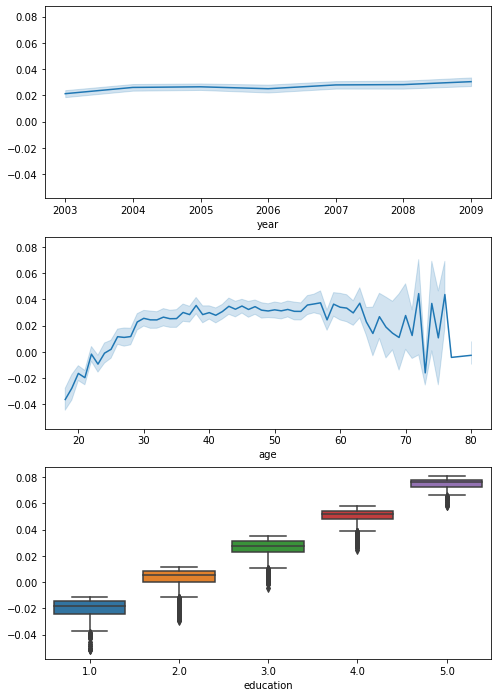

In [26]:
gam_plot('year', 'age', 'education', wage, model_gam2)

In [27]:
X = patsy.dmatrix('year + cr(age, df=5) + education', wage)
y = np.asarray(wage['wage_above_250'])
model_gam3 = sm.Logit(y, X).fit(disp=0)

In [28]:
pd.pivot_table(wage, values=['wage_above_250'],\
               index='education', aggfunc=['sum', 'count'])

,sum,count
,wage_above_250,wage_above_250
education,,
1.0,0.0,268
2.0,5.0,971
3.0,7.0,650
4.0,22.0,685
5.0,45.0,426


In [29]:
wage_sub = wage[wage['education']!=1]

X = patsy.dmatrix('year + cr(age, df=5) + education', wage_sub)
y = np.asarray(wage_sub['wage_above_250'])
model_gam4 = sm.Logit(y, X).fit(disp=0)
model_gam4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2732
Model:                          Logit   Df Residuals:                     2725
Method:                           MLE   Df Model:                            6
Date:                Fri, 06 Mar 2020   Pseudo R-squ.:                  0.1567
Time:                        18:19:38   Log-Likelihood:                -301.70
converged:                       True   LL-Null:                       -357.77
Covariance Type:            nonrobust   LLR p-value:                 7.244e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -47.2564        nan        nan        nan         nan         nan
x1             0.0234      0.058      0.405      0.686      -0.090       0.137
x2           -14.9236        nan        nan        nan         nan         nan
x3            -7.5040        nan        nan        nan         nan         nan
x4            -7.0826        nan        nan        nan         nan         nan
x5            -6.7605        nan        nan        nan         nan         nan
x6           -10.9854        nan        nan        nan         nan         nan
x7             1.0505      0.135      7.778      0.000       0.786       1.315
==============================================================================
"""

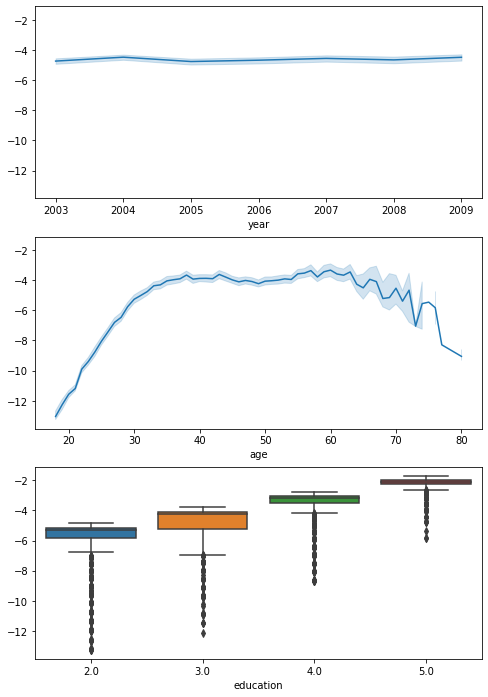

In [30]:
gam_plot('year', 'age', 'education', wage_sub, model_gam4)

In [2]:
from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

## 6. In this exercise, you will further analyze the Wage data set considered throughout this chapter.

### (a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

In [5]:
wage_df = pd.read_csv('./data/Wage.csv')
wage_df = wage_df.drop(wage_df.columns[0], axis=1)

wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### Cross val

In [6]:
def ols_cv(formula, X, y, k):
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)


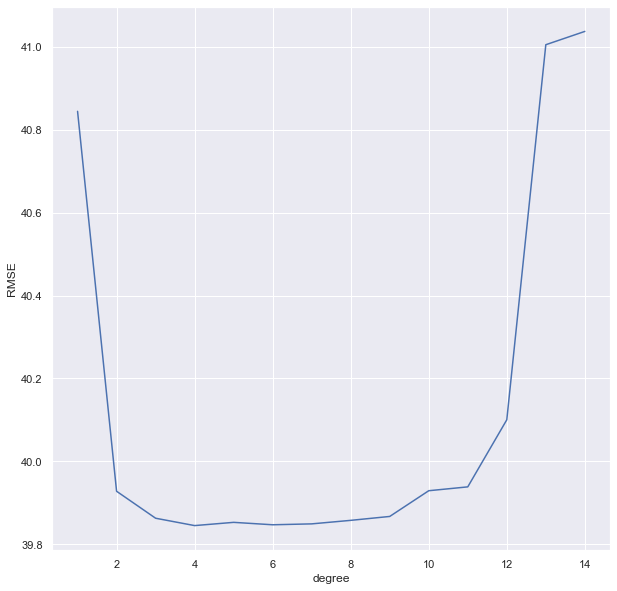

Min RMSE : 39.84520702162396
Degree   : 4


In [7]:
results = [] 
for d in np.arange(1,15):
    f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, d+1)])
    X = pt.dmatrix(f, wage_df)
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], d)]
    
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'degree': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='degree', y='RMSE', data=df, color='b', ax=ax)
plt.show();

print('Min RMSE : {}'.format(min(results)[0]))
print('Degree   : {}'.format(min(results)[1]))

### ANOVA

In [8]:
degree = 5
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, wage_df)
y = np.asarray(wage_df['wage'])

model_1 = sm.OLS(y, X[:, 0:2]).fit()
model_2 = sm.OLS(y, X[:, 0:3]).fit()
model_3 = sm.OLS(y, X[:, 0:4]).fit()
model_4 = sm.OLS(y, X[:, 0:5]).fit()
model_5 = sm.OLS(y, X[:, 0:6]).fit()

display(sm.stats.anova_lm(model_1, model_2, model_3, model_4, model_5))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


**Comment:** Cross validation chooses a 4th degree polynomial model. Anova selects the 3rd degree model which scores only marginally below optimal in cross validation. It would be interesting to see which performs best in test.

### (b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number of cuts. Make a plot of the fit obtained.

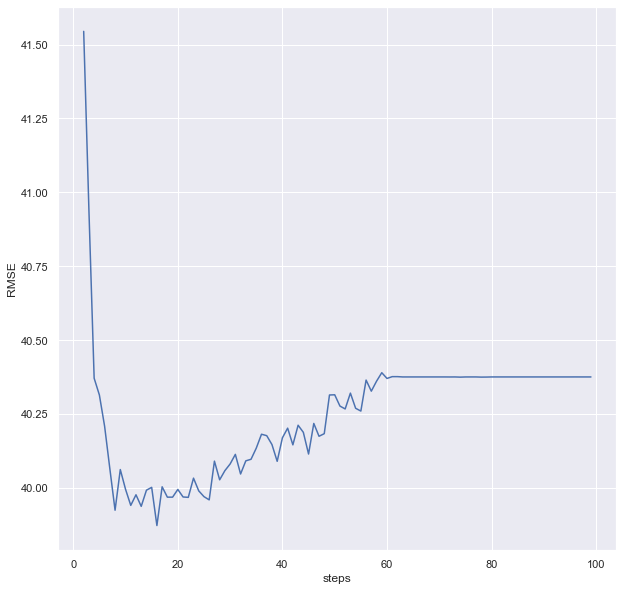

Min RMSE : 39.872054703507914
Steps   : 16


In [9]:
results = [] 
for steps in np.arange(2,100):
    cuts = pd.cut(wage_df['age'], steps)
    X = np.asarray(pd.get_dummies(cuts))
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], steps)]
    
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'steps': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='steps', y='RMSE', data=df, color='b', ax=ax)
plt.show();

print('Min RMSE : {}'.format(min(results)[0]))
print('Steps   : {}'.format(min(results)[1]))

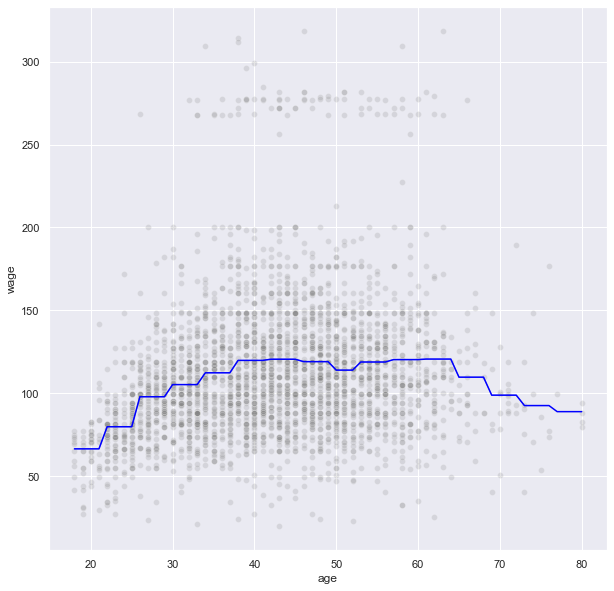

In [10]:
steps = min(results)[1]

cuts = pd.cut(wage_df['age'], steps)
X = np.asarray(pd.get_dummies(cuts))
y = np.asarray(wage_df['wage'])

model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)

fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=pd.concat([wage_df['age'], wage_df['wage']], axis=1));

sns.lineplot(x=wage_df['age'], y=y_hat, ax=ax, color='blue')
plt.show()

## 7. The Wage data set contains a number of other features not explored in this chapter, such as marital status (maritl), job class (jobclass), and others. Explore the relationships between some of these other predictors and wage, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

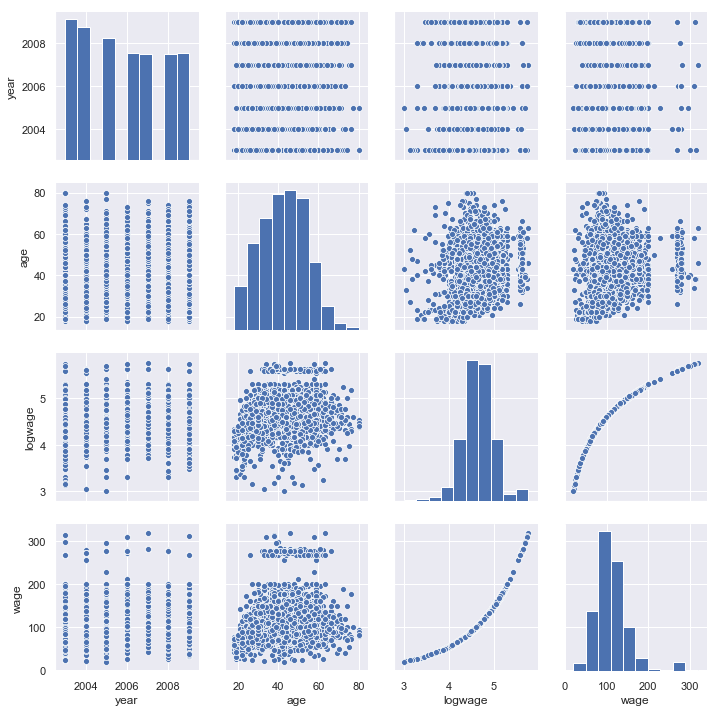

In [7]:
sns.pairplot(data=wage_df)

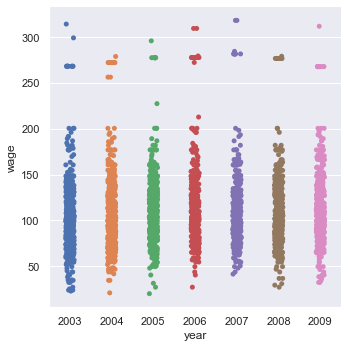

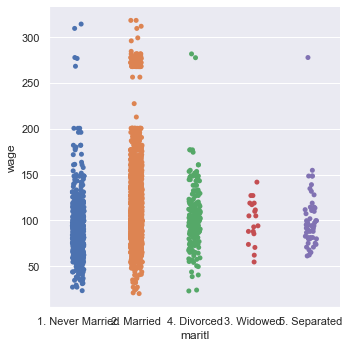

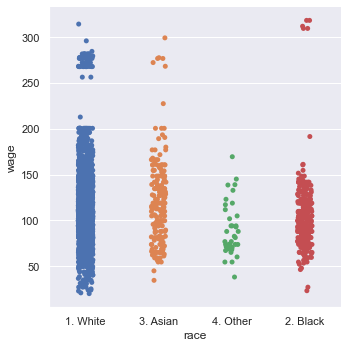

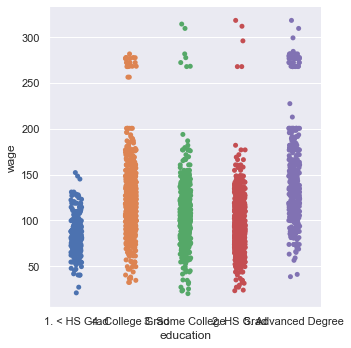

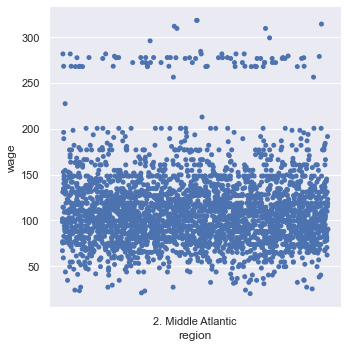

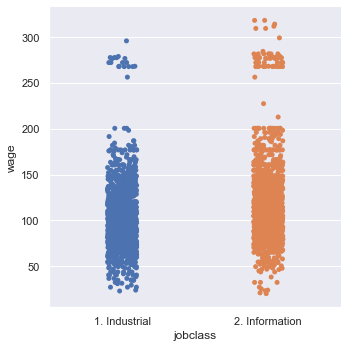

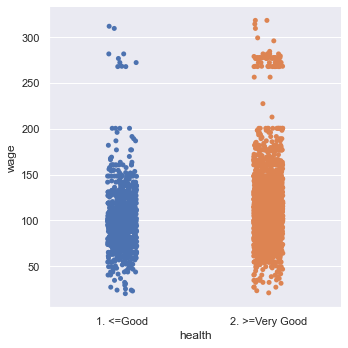

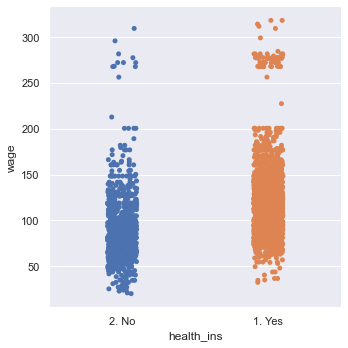

In [11]:
categoricals = wage_df.drop(['age', 'logwage', 'wage'], axis=1).columns
for c in categoricals:
    sns.catplot(x=c, y='wage', data=wage_df)

Notes:

- region only has one value so should be ignored
- health and health_ins look quite similar so only one of those might be needed
- age we know from above that 4 degree polynomial models well
- education we know from lab is best modelled as linear
- log wage is just log of wage so we'll drop it


In [9]:
wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### So how to find the best model?

We know that:

- age is nonlinear 
- education is fairly linear
- year is linear
- logwage, and region can be ignored
- the rest are linear dummy variables


Approaches I can think of:

- come up with some rang of models with different features and degrees of freedom then compare
- find the best model for each predictor feature indivivudally (slow) then combine with a GAM
- create a big GAM with basis functions appropriate to what is known so far, then perform backward stepwise selection

Let's try the latter.


In [12]:
# Treat education as ordinal
wage_df['education'] = wage_df['education'].map({'1. < HS Grad': 1.0, 
                                                 '2. HS Grad': 2.0, 
                                                 '3. Some College': 3.0,
                                                 '4. College Grad': 4.0,
                                                 '5. Advanced Degree': 5.0
                                                })
wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### Approach 1 – Naive backward stepwise selection

Min RMSE            : 33.954748128650536
Best predictor count: 16


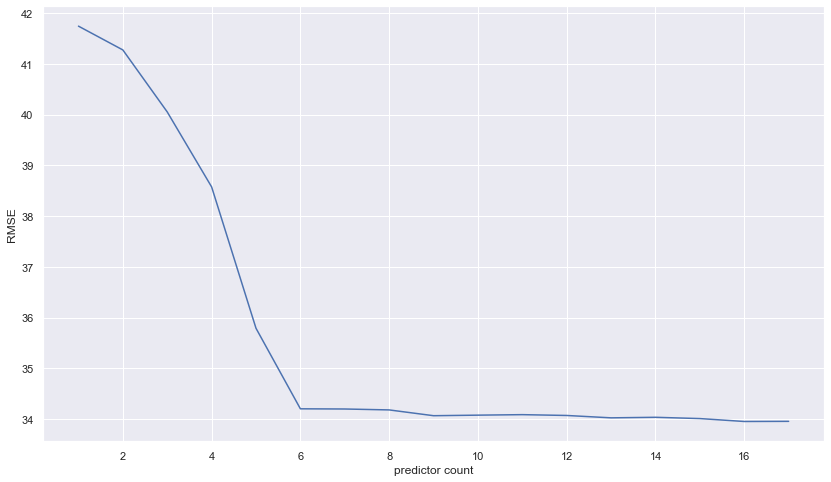

,predictor,selected
0,Intercept,True
1,C(maritl)[T.2. Married],True
2,C(maritl)[T.3. Widowed],True
3,C(maritl)[T.4. Divorced],False
4,C(maritl)[T.5. Separated],True
5,C(race)[T.2. Black],True
6,C(race)[T.3. Asian],True
7,C(race)[T.4. Other],True
8,C(jobclass)[T.2. Information],True
9,C(health)[T.2. >=Very Good],True


In [13]:
# Create features
f = 'year + education + cr(age, df=4) + C(maritl) + C(race) + C(jobclass) + C(health) + C(health_ins)'
X = pt.dmatrix(f , wage_df)
y = np.asarray(wage_df['wage'])

# Backward stepwise feature selection
estimator = LinearRegression(fit_intercept=False)
selector = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

# Best model stats
RMSEs_backward  = np.sqrt(np.abs(selector.grid_scores_))
predictor_count = np.arange(1, 1+len(RMSEs_backward))
print('Min RMSE            : {}'.format(min(RMSEs_backward)))
print('Best predictor count: {}'.format(np.sum(selector.support_)))

# Plot RMSE for each step
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(x='predictor count', y='RMSE', ax=ax, 
             data=pd.DataFrame({'RMSE': RMSEs_backward, 'predictor count': predictor_count}))
plt.show();

# Show selected features
display(HTML('<h4>Features selected</h4>'))
display(pd.DataFrame({'predictor': X.design_info.column_names,
                      'selected': selector.ranking_ == 1}))

Backward stepwise selects a model with all features except 'Divorced', reporting an RMSE of 33.97. A marked improvement on the best RMSE achieved for univariate regression of age with 4 degree polynomial: 39.8.

**Revision note:** Backward stepwise doesn't seem to be appropriately selecting the degrees of freedom for age. For example, when df=50 all degrees of freedom are selected with an RMSE of 34.05 for that model. The RMSE for a model with around 17 predictors is ~34.05, worse than when we observe above, suggesting that backward stepwise is unable to find the optimal degrees of freedom for age with this approach. 

I think the problem is that when we use patsy `cr()` command we specify the degrees of freedom at this point and the appropriate features are created. In the approach above I assumed that if we call `cr(ag, df=10)` then only use the first 5 resultant age featutes then that would be equivalent to cubic regression with df=5 – this assumption is fales, it would be true for polynomial features but not for spline features which presumable represent each knot.

**Note:** sklearn's RFECV functions used here for backward stepwise doesn't allow us to set the random seed used for k-fold splits, which means that there will be variance when trying to reproduce above results. I've observed this effect by running the above mult times. This is bad science, we really need a method that is reproducible.


### Approach 2 – Selection of optimal DOF for age by cross valiation, then backward stepwise treating age spline features as single feature

#### Step 1

Choose optimal degrees of freedom for age by holding all other predictors still whilst varying dof, then testing with cross validations.

In [14]:
def ols_cv(formula, X, y, k):
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        model = sm.OLS(y_train, X_train).fit()
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)

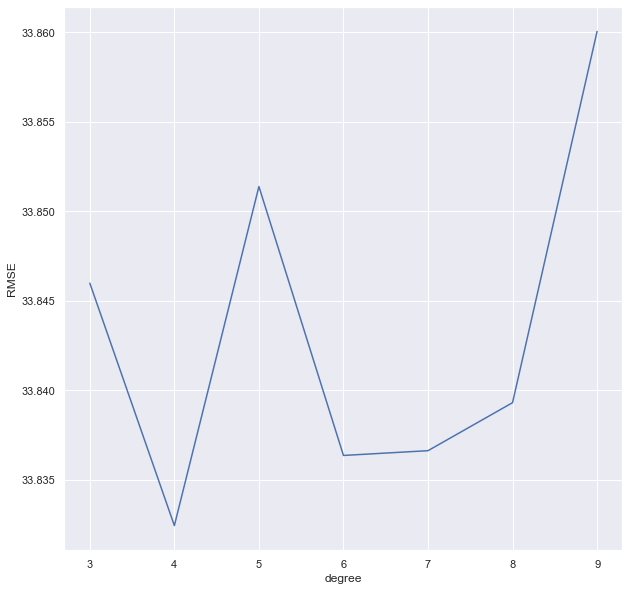

Min RMSE : 33.832439602587094
Degree   : 4


In [15]:
# Perform CV for increasing polynomial order
results = [] 
for d in np.arange(3,10):
    f = 'year + education + cr(age, df={}) + C(maritl) + C(race) + C(jobclass) + C(health) + C(health_ins)'.format(d)
    X = pt.dmatrix(f, wage_df)
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], d)]
    
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'degree': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='degree', y='RMSE', data=df, color='b', ax=ax)
plt.show();

print('Min RMSE : {}'.format(min(results)[0]))
print('Degree   : {}'.format(min(results)[1]))

#### Step 2

Estimate best subset of features in each subset of p predictors using backward stepwise selection.

In [16]:
def backward_stepwise_patsy(predictors, response, data, scorer='ssr', results=[]):
    # List predictors that havent's been used so far
    p_all = predictors

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(response, '+'.join(p_all))
        model = smf.ols(formula=f, data=data).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(response, '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=data).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise_patsy(predictors, response, data, scorer, new_results)

In [17]:
def subset_analysis(df, scorer):
    df['predictors_str'] = df['predictors'].astype(str)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False, ax=ax)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
        return df
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))
        return df

In [18]:
def ols_cv_patsy(formula, data, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    y, X = pt.dmatrices(formula, wage_df)
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)

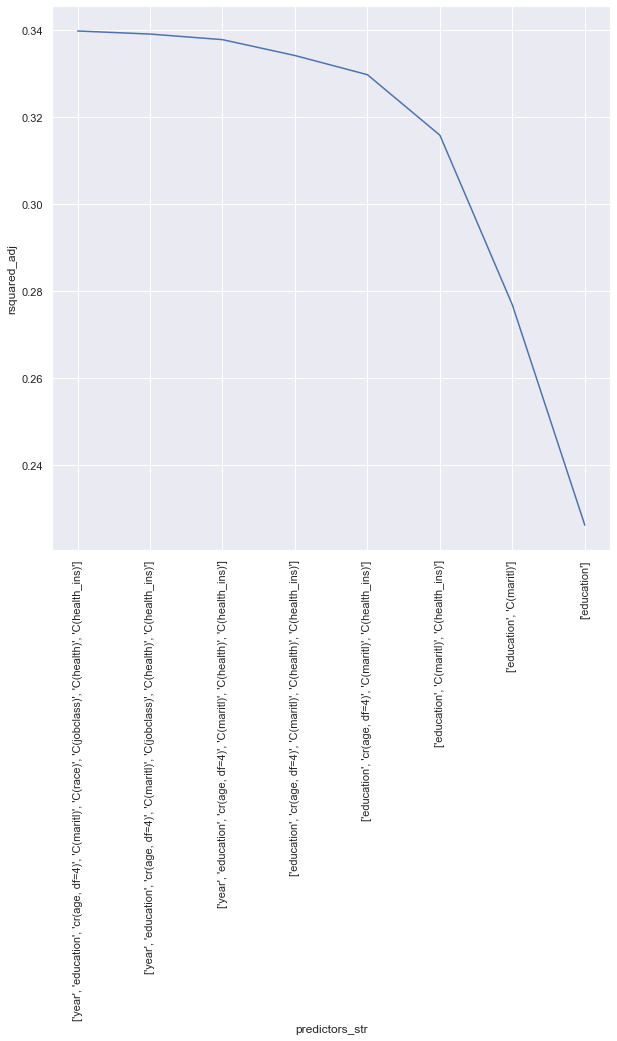

,rsquared_adj,predictors
0,0.339702,"[year, education, cr(age, df=4), C(maritl), C(..."


In [19]:
response = 'wage'
predictors = ['year', 
              'education', 
              'cr(age, df=4)', 
              'C(maritl)',
              'C(race)',
              'C(jobclass)',
              'C(health)',
              'C(health_ins)']


results = subset_analysis(backward_stepwise_patsy(predictors, response, wage_df, scorer='rsquared_adj'), 'rsquared_adj')

#### Step 3

Compare best models in each subset with 10-fold cross validation.

In [20]:
predictor_subsets = list(results['predictors'])
reponse = 'wage'
r = []
for p in predictor_subsets:
    f     = '{} ~ {}'.format(response, '+'.join(p))
    # Fit model
    r += [ols_cv_patsy(f, wage_df, 10)]
    

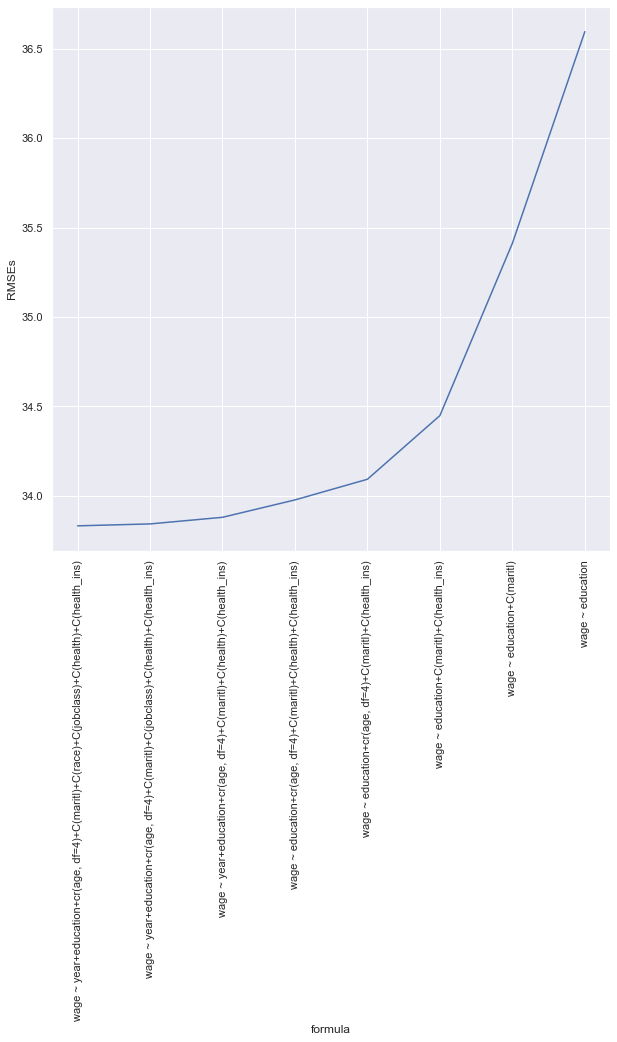

Min RMSE: 33.832439602587094
Model   : wage ~ year+education+cr(age, df=4)+C(maritl)+C(race)+C(jobclass)+C(health)+C(health_ins)


In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='formula', y='RMSEs', ax=ax, sort=False,
             data=pd.DataFrame({'RMSEs': [i[0] for i in r], 'formula': [i[1] for i in r]}))
plt.xticks(rotation=90)
plt.show();

print('Min RMSE: {}'.format(min(r)[0]))
print('Model   : {}'.format(min(r)[1]))

We a arrive at a model that achives an RMSE CV score of 33.83, marginally lower than that achieved in approach 1 (33.97).

The selected model uses all features with 4 degrees of freedom for a cubic regression spline on age.

## 11. In Section 7.7, it was mentioned that GAMs are generally fit using a backfitting approach. The idea behind backfitting is actually quite simple. We will now explore backfitting in the context of multiple linear regression.

## Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient esti- mate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued un- til convergence—that is, until the coefficient estimates stop changing.

## We now try this out on a toy example.


At this point I start playing around with 3d visualisation, I don't know why...

Not relevant to this question, but leaving here because it is interesting.

In [22]:
x1 = np.arange(-5, 5, 1)
x2 = np.arange(-5, 5, 1)
xx1, xx2 = np.meshgrid(x1, x2, sparse=False)
X = np.asarray([xx1.flatten(), xx2.flatten()]).T
y = (2*xx1**3 + 5*xx2**2).flatten() + np.random.normal(0, 10, 100)

def plot_3d_b(yaw, pitch):
    fig = plt.subplots(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(X[:,0], X[:,1], y, linewidth=0.2, antialiased=True)

    # Rotate it
    ax.view_init(pitch, yaw)
    plt.show()    
    
interact(plot_3d_b, 
         yaw=widgets.FloatSlider(min=1, max=360, step=10, value=230),
         pitch=widgets.FloatSlider(min=1, max=360, step=10, value=20));

interactive(children=(FloatSlider(value=230.0, description='yaw', max=360.0, min=1.0, step=10.0), FloatSlider(…

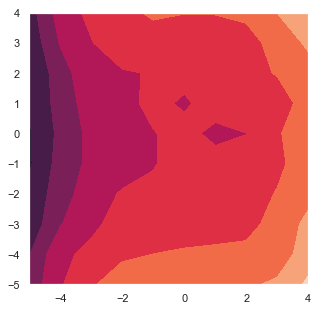

In [20]:
# Contour plot
fig = plt.subplots(figsize=(5, 5))
ax.contourf(x1, x2, y.reshape(10,10));

### (a) Generate a response Y and two predictors X1 and X2, with n = 100.

In [23]:
np.random.seed(1)
x1  = np.random.normal(0, 1, 100)
x2  = np.random.normal(0, 1, 100)
eps = 0.1 * np.random.normal(0, 1, 100)

X = np.asarray([np.ones(100), x1, x2]).T
y = 0.2 + 2*x1 + 5*x2 + eps

### (c) Keeping $β_1$ fixed, fit the model 

$$y − β_1 X_1 = β_0 + β_2 X_2 + ε$$

Ordinary least squares regression is defined by the matrix operation:

$$\hat{β} = (X^T X)^{-1}X^T y$$

In [22]:
beta1 = 20
ya = y - (beta1*x1)
Xa = np.asarray([np.ones(100), x2]).T

beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
print(beta_hat)

beta2 = beta_hat[1]

[-0.65602756  3.47192688]


### (d) Keeping $β_2$ fixed, fit the model 

$y − β_2 X_2 = β_0 + β_1 X_1 + ε$

In [23]:
ya = y - (beta2*x2)
Xa = np.asarray([np.ones(100), x1]).T

beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
print(beta_hat)

#beta1 = beta_hat[1]

[0.42587836 2.14171377]


### (e) Write a for loop to repeat (c) and (d) 1,000 times. Report the estimates of βˆ0, βˆ1, and βˆ2 at each iteration of the for loop. Create a plot in which each of these values is displayed, with βˆ0, βˆ1, and βˆ2 each shown in a different color.

In [24]:
beta1 = 100

results= []
for i in range(20):
    ya = y - (beta1*x1)
    Xa = np.asarray([np.ones(100), x2]).T
    beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya 
    beta2 = beta_hat[1]
    ya = y - (beta2*x2)
    Xa = np.asarray([np.ones(100), x1]).T
    beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
    beta1 = beta_hat[1]
    
    beta0 = beta_hat[0]
    results += [[beta0, beta1, beta2]]

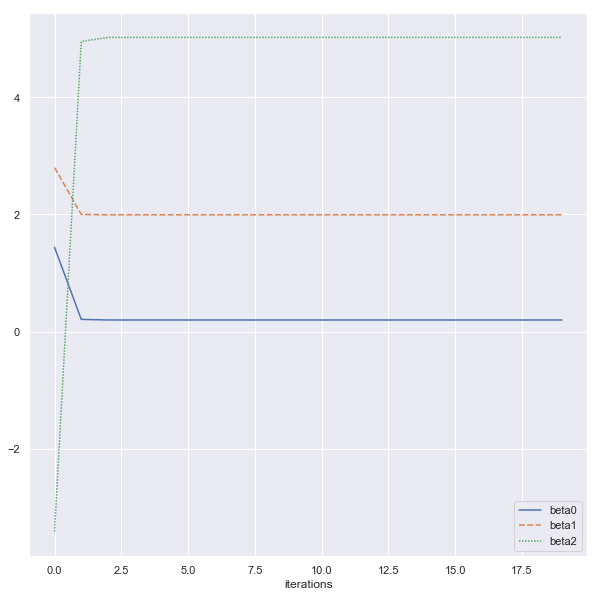

In [25]:
fig = plt.subplots(figsize=(10, 10))
sns.lineplot(data=pd.DataFrame(np.asarray(results), columns=['beta0','beta1','beta2']))
ax.set(xlabel='iterations')

### (f) Compare your answer in (e) to the results of simply performing multiple linear regression to predict Y using X1 and X2. Use the abline() function to overlay those multiple linear regression coefficient estimates on the plot obtained in (e).

In [26]:
beta_hat = (np.linalg.inv((X.T @ X)) @ X.T) @ y
beta_hat

array([0.19802058, 1.99381028, 5.02183714])

In [27]:
# Plot comparison of results from backfitting and multivariate linear regression
backfit   = np.asarray(results)
multi_ols = np.ones([r.shape[0], r.shape[1]]) * beta_hat
data      = np.concatenate((backfit, multi_ols), axis=1)
cols = ['beta0_backfit','beta1_backfit','beta2_backfit', 'beta0_multi','beta1_multi','beta2_multi']
plot_df = pd.DataFrame(data, columns=cols)

fig = plt.subplots(figsize=(10, 10))
sns.lineplot(data=plot_df)
ax.set(xlabel='iterations');
#plt.axhline(y=beta_hat[0], linestyle='--')

AttributeError: 'list' object has no attribute 'shape'

### (g) On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple regression coefficient estimates?

Two

### 12. This problem is a continuation of the previous exercise. In a toy example with p = 100, show that one can approximate the multiple linear regression coefficient estimates by repeatedly performing simple linear regression in a backfitting procedure. How many backfitting iterations are required in order to obtain a “good” approximation to the multiple regression coefficient estimates? Create a plot to justify your answer.

In [28]:
def gen_data(n, p):
    np.random.seed(1)
    # Generate 100 random observations for 100 predictors
    predictors = np.random.normal(0, 1, (n, p))
    # Add bias variable
    X = np.insert(predictors, 0, 1, axis=1)
    # Generate random beta coefficients
    beta_true = np.random.randint(0, 10, size=X.shape[1]).astype(np.float64)
    # Derive true y
    eps = 0.1* np.random.normal(0, 1, n)
    y = beta_true @ X.T + eps
    
    # Initalize beta at some random values
    beta_rand = list(np.random.randint(0, 10, size=X.shape[1]).astype(np.float64))
    
    return X, y, beta_true, beta_rand


def backfit(X, y, iterations:int, beta_ests:list):
    """Perform backfitting algorithm to recursively estimate
    beta parameters one at a time"""
    
    # Exit recursion
    if len(beta_ests) == iterations:
        return np.asarray(beta_ests)
    
    # Start recursion or iterate 
    beta_prev = copy.deepcopy(beta_ests[-1])
    beta_new  = np.zeros(len(beta_prev))
    
    # Perform one backfitting iteration to generate new set of estimates for all beta
    for j in  np.arange(1, X.shape[1]):
        # - Exclude predictors for which params are not being estimated in this pass (except intercept)
        # - Isolate predictors for which param is to be estimated in this pass
        # - Perform Ordinary Least Squares regression
        y_b = y - (np.delete(beta_prev[1:], j-1) @ np.delete(X[:, 1:], j-1, axis=1).T)
        X_b = X[:, [0,j]]
        beta_est = (np.linalg.inv((X_b.T @ X_b)) @ X_b.T) @ y_b
        
        # Save estimates, but include intercept estimate on first pass only
        if j == 1:
            beta_new[0] = beta_est[0]
            beta_new[1] = beta_est[1]
        else:
            beta_new[j] = beta_est[1]
    
    # Recur
    return backfit(X, y, iterations, beta_ests+[beta_new])


def backfit_plot(n, p, iterations):
    # Gen simulated data
    X, y, beta_true, beta_rand = gen_data(n, p)
    
    beta_ests = backfit(X, y, iterations, [beta_rand])
    cols = ['x{}'.format(i) for i in range(p+1)]
    
    fig = plt.subplots(figsize=(10, 10))
    for i in range(p+1):
        # Plot estimated coefficient
        sns.lineplot(data=beta_ests[:, i]);
        # Plot true coefficient
        plt.axhline(y=beta_true[i], linestyle='--')
    ax.set(xlabel='iterations')
    ax.set(ylabel='coefficients (β)')
    plt.show();
    #return beta_ests

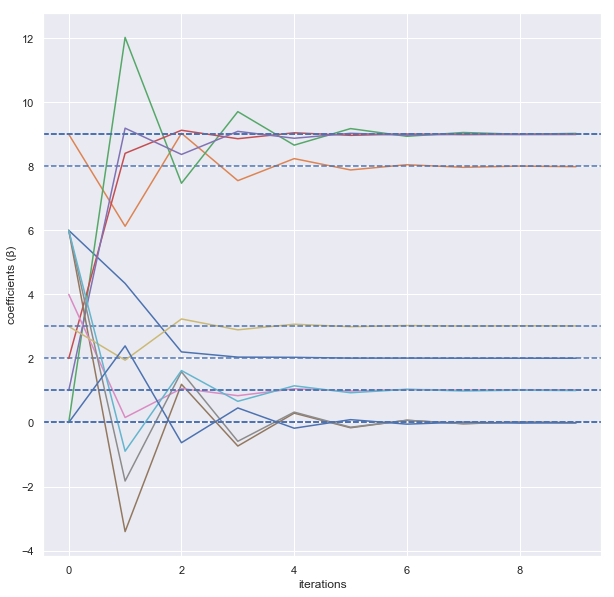

In [29]:
backfit_plot(n=100, p=10, iterations=10);

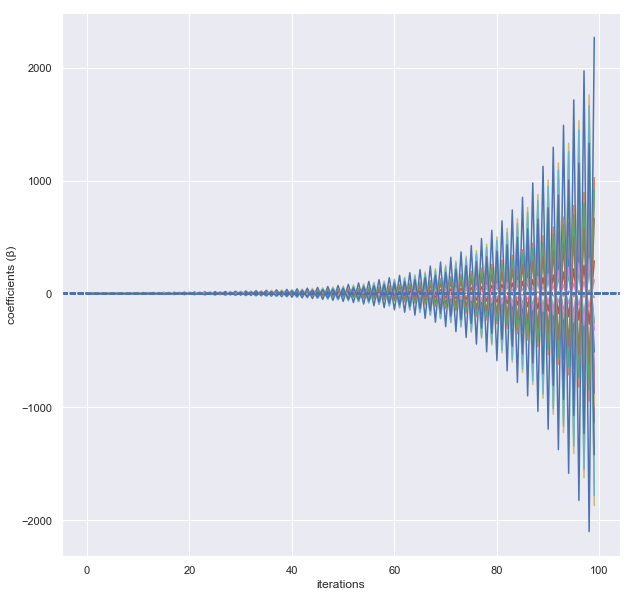

In [30]:
backfit_plot(n=100, p=20, iterations=100);

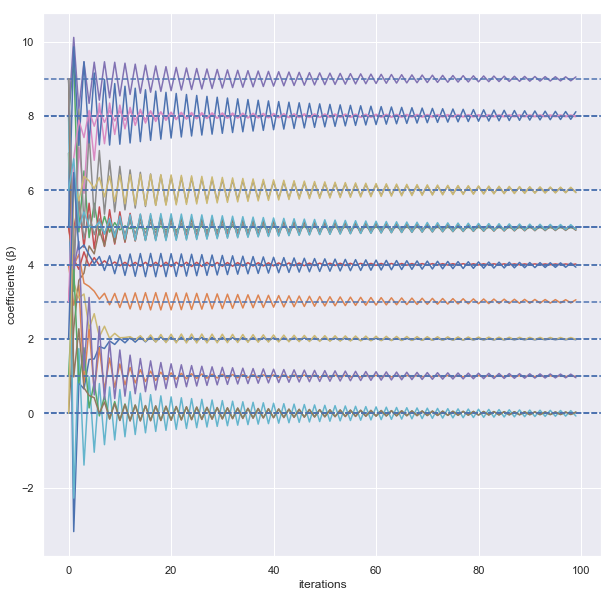

In [31]:
backfit_plot(n=110, p=20, iterations=100);

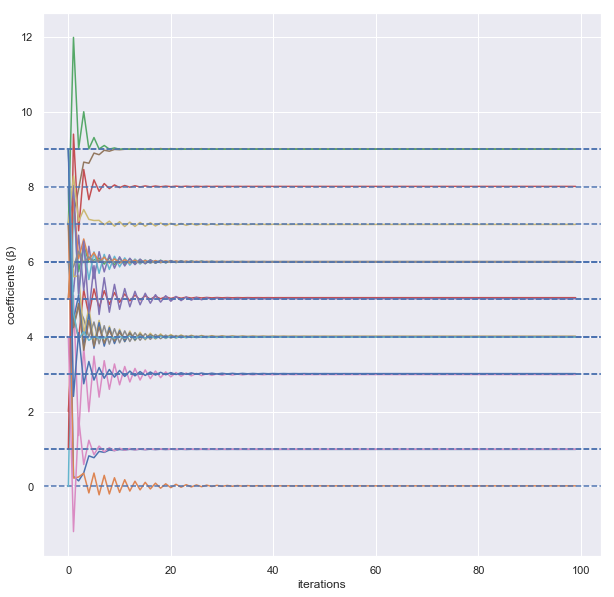

In [32]:
backfit_plot(n=120, p=20, iterations=100);

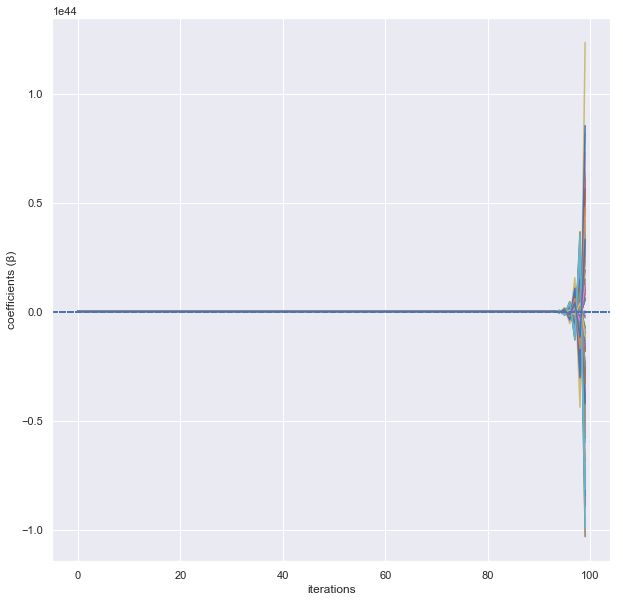

In [33]:
backfit_plot(n=100, p=100, iterations=100);

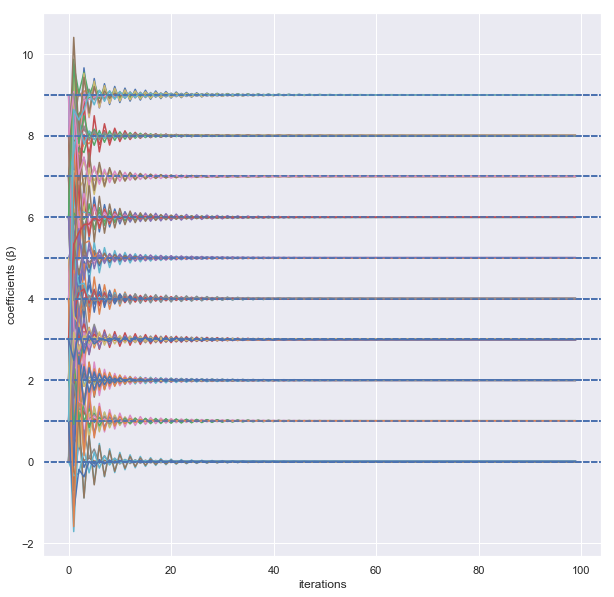

In [34]:
backfit_plot(n=650, p=100, iterations=100);

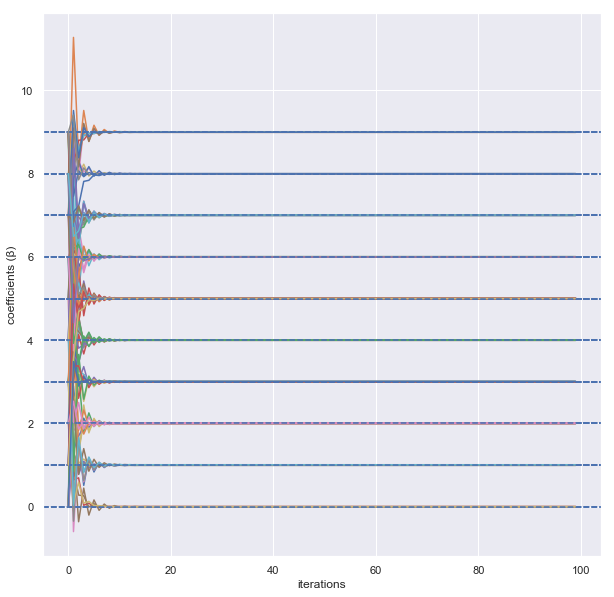

In [35]:
backfit_plot(n=1000, p=100, iterations=100);

**Comment:**

Above I've plotted the coefficient estimates at each iteration from backfitting with data simulated from linear models with various numbers of predictors and observations. On each plot horizontal dashed lines show the true coefficient values.

We can see that in some cases the backfitting estimates converge to the true value, and in some cases estimates are divergent.

Convergence is dependant on the number of predictors p AND the number of observation n. Convergence is not observed when n < p. The factor by which n must be greater than p in order for convergence to occur doesn't seem to be constant, seems to be in the range 1.2p-10p

Once the threshold of convergence is achieved, further increasing the ratio n:p serves to reduce the number of iterations required for a given level of convergence.

To get an intuition for this intercaiton its worth playing around with the sliders below. Start by increasing p until estimates start to converge, then increase n until convergence reoccurs.

In [40]:
interact(backfit_plot, 
         n=widgets.IntSlider(min=10, max=1000, step=20, value=100),
         p=widgets.IntSlider(min=2, max=100, step=5, value=10),
         iterations=widgets.IntSlider(min=10, max=20, step=10, value=10));

interactive(children=(IntSlider(value=100, description='n', max=1000, min=10, step=20), IntSlider(value=10, de…